# Compresión de Imágenes usando PCA

Históricamente, uno de los primeros usos de **PCA** en el área de procesamiento de imágenes fue como método de compresión. 

Si tenemos una imagen de tamaño $H \times W $ píxeles, esta se subdivide en bloques de $C \times C $ píxeles (por ejemplo, tomar $C $ un factor común de las dimensiones $H $ y $W $ de la imagen). Con los valores de los píxeles en cada bloque se forma un vector:

$$
\mathbf{b}_i = (x_1, x_2, \dots, x_{c^2}) \in \mathbb{R}^{c^2}
$$

La matriz de datos se forma con todos estos vectores provenientes de los bloques $i $ vectorizados. 

La **compresión** consiste en proyectar los datos sobre los primeros $k $ componentes principales, mientras que la **descompresión** consiste en reconstruir la imagen a su tamaño original $H \times W $ a partir de estas proyecciones.

## Implementación

Se implementará lo anterior para varias imágenes (en escala de grises o a color) y mostrar el efecto del valor de $k $ sobre la calidad de la reconstrucción. 

- Se Analizará cómo cambia el **error de reconstrucción** y la **calidad visual** a medida que se incrementa o disminuye $k $.
- Se mostrará los resultados obtenidos de al menos **3 imágenes**.


### Importacion de librerias a utilizar

In [1232]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

### Obtener las imágenes originales y mostrarlas

In [1233]:
"""
Carga una lista de imágenes en formato RGB.

@param path_list (list[str]): Lista de rutas de imágenes a cargar.
@return (list[np.ndarray]): Lista de imágenes cargadas como NumPy arrays con canales RGB.
"""
def loadImages(path_list):
    images_rgb = [mpimg.imread(path_list[i])[:, :, :3] for i in range(len(path_list))]
    return images_rgb

In [1234]:
ruta_principal = "./images/"
n_images = ["compress1.png","compress2.jpg","compress3.png"]
n_images = [f"{ruta_principal}{n_images[i]}" for i in range(len(n_images))]
images = loadImages(path_list=n_images)

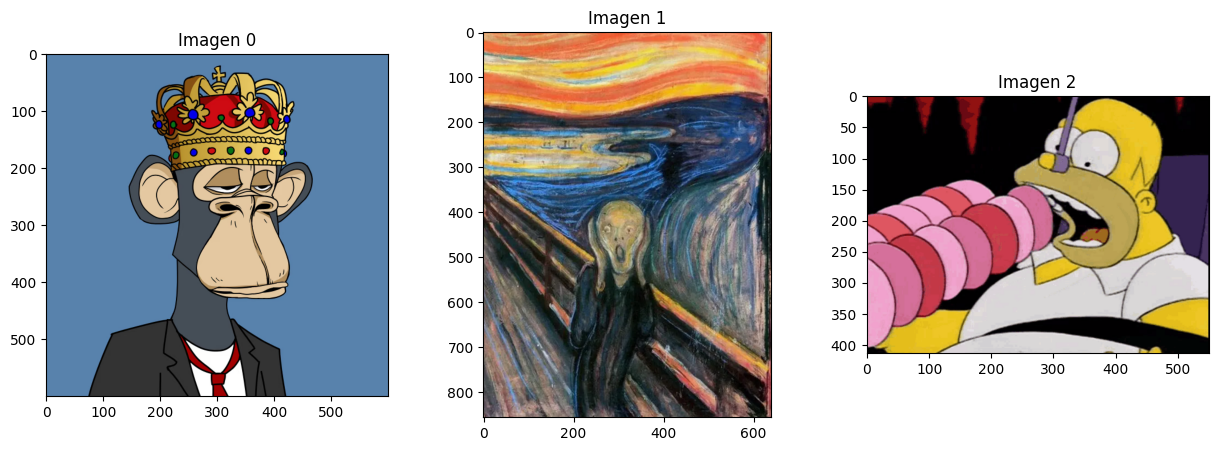

In [1235]:
_, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(15, 5))

for i in range(len(images)):
    axs[i].imshow(images[i])
    axs[i].set_title(f"Imagen {i}")

plt.show()

### Centralización de datos

Este paso es fundamental en el Análisis de Componentes Principales (PCA) para evitar que las variables con valores más grandes tengan un peso desproporcionado en el análisis. En el caso de imágenes, la estandarización se puede aplicar a los colores, tanto por filas como por columnas, utilizando NumPy de manera sencilla y la sintaxis para ejes `axis=(0,1)`:

- Realiza la operación (media y desviación estándar) de cada canal en toda la imagen.
- Para este caso es un vector de 3 valores que contiene ya sea la media o desviación estándar de cada canal (RGB).

In [1236]:
"""
Estandariza una imagen normalizando sus valores con la media y desviación estándar.

@param data (np.ndarray): Imagen en formato NumPy array con canales RGB.
@return (tuple[np.ndarray, np.ndarray, np.ndarray]): Imagen estandarizada, media y desviación estándar por canal.
"""
def standardizeData(data):
  mu = data.mean(axis=(0,1))
  std = data.std(axis=(0,1))
  data_standar = (data - mu) / std
  return data_standar, mu, std


### **Compresión y Descompresión**  

Dado que las imágenes se manejan en color y no en escala de grises (lo que implicaría un cálculo y aplicación más sencilla), el conjunto de datos tendrá un tamaño de $ (h, w, 3) $. Esto significa que cada imagen en el dataset contará con $ h $ filas y $ w $ columnas, donde cada posición de la matriz representa un píxel. A su vez, cada píxel está asociado a un vector de tamaño $ 1 \times 3 $, que almacena los valores de color en el formato RGB.  

Por lo tanto, la compresión no se realizará de la forma $ X_k = X_c @ (V[:k,:].T) $, ya que en este caso la descomposición no se aplica sobre toda la matriz, sino sobre las matrices que conforman cada canal de color. Se realiza **SVD** por separado para cada canal **R, G y B**, y posteriormente se lleva a cabo la descompresión en cada uno.  

Si se aplicara la descomposición sobre toda la matriz general, los colores se mezclarían, por lo que es necesario realizar la compresión de forma independiente para cada píxel, considerando que este se compone de tres valores de color, a diferencia de una imagen en escala de grises, que solo tiene una intensidad en una matriz bidimensional.  

Luego de realizar la compresión, se obtienen los $ k $ componentes principales (descompresión) de cada canal de color, y finalmente se vuelven a unir mediante `np.stack()`. Esto permite reconstruir la matriz en un formato tridimensional, donde los colores se organizan correctamente en la **tercera dimensión** (`axis=2`), obteniendo nuevamente una matriz de tamaño $ (h, w, 3) $ para su visualización.

In [1237]:
"""
Aplica la Descomposición en Valores Singulares (SVD) a una imagen y la reconstruye con los primeros k componentes.

@param data (np.ndarray): Imagen en formato NumPy array con canales RGB.
@param std (np.ndarray): Desviación estándar utilizada en la normalización.
@param mu (np.ndarray): Media utilizada en la normalización.
@param k_value (int): Número de componentes principales a utilizar en la reconstrucción.

@return (np.ndarray): Imagen reconstruida con los primeros k componentes principales.
"""
def doSVD(data, std, mu, k_value):
  U_r, S_r, Vt_r = np.linalg.svd(data[:,:,0], full_matrices=False)
  U_g, S_g, Vt_g = np.linalg.svd(data[:,:,1], full_matrices=False)
  U_b, S_b, Vt_b = np.linalg.svd(data[:,:,2], full_matrices=False)

  # Reconstrucción de cada canal con k componentes
  R_recon = U_r[:, :k_value] @ np.diag(S_r[:k_value]) @ Vt_r[:k_value, :]
  G_recon = U_g[:, :k_value] @ np.diag(S_g[:k_value]) @ Vt_g[:k_value, :]
  B_recon = U_b[:, :k_value] @ np.diag(S_b[:k_value]) @ Vt_b[:k_value, :]
  
  # Unir los canales reconstruidos
  image_recon = np.stack([R_recon, G_recon, B_recon], axis=2)

  # Deshacer la estandarización (revertir el escalado)
  image_recon = (image_recon * std) + mu

  # Asegurar que los valores están en el rango [0, 1]
  image_recon = np.clip(image_recon, 0, 1)
  
  return image_recon

### **Error y Eficiencia**  

El **error de reconstrucción** se define como la **suma de los residuos ortogonales**, es decir, la diferencia entre los datos originales y sus proyecciones en el subespacio reducido:  

$$
\text{Error Total} = \sum_{i=1}^{n} ||x_i - \hat{x}_i||^2
$$

Donde:  
- $ x_i $ → Vector de características original del dato $ i $.  
- $ \hat{x}_i $ → Proyección del vector $ x_i $ en el subespacio reducido.  
- $ n $ → Número total de datos.  

En términos de optimización, minimizamos el error cuadrático medio (MSE) para obtener la mejor aproximación de los datos originales:  

$$
\min \frac{1}{n} \sum_{i=1}^{n} ||x_i - \hat{x}_i||^2
$$

La **eficiencia de compresión** mide cuánto se ha reducido el tamaño de la imagen al utilizar solo **$ k $** componentes en lugar de almacenar la imagen completa.  

Se define como:  

$$
\text{Tamaño Comprimido} = H \times W \times 3
$$

$$
\text{Tamaño Comprimido} = 3 \times ( H \times k + k + k \times W )
$$

$$
\text{Eficiencia} = 1 - \frac{\text{Tamaño Comprimido}}{\text{Tamaño Original}}
$$

Donde:  
- **Tamaño original**:
  - $ H $ → Altura de la imagen en píxeles.
  - $ W $ → Ancho de la imagen en píxeles.
  - $ 3 $ → Número de canales de color (R, G, B).
- **Tamaño comprimido con $ k $ componentes**:  
  - **Para cada canal** en SVD, guardamos:
    - **Matriz $ U_k $**: $ H \times k $ (representa los vectores propios de la imagen en la dimensión reducida).
    - **Matriz $ S_k $**: $ k $ valores singulares (que indican la importancia de cada componente principal).
    - **Matriz $ V^T_k $**: $ k \times W $ (contiene la información de cómo reconstruir la imagen a partir de los vectores propios).
    - $ 3 $ → Número de canales de color (R, G, B).

In [1238]:
def calculateRecError(original, reconstructed):
  """
  Calcula el error de reconstrucción usando la métrica de PCA basada en residuos ortogonales.

  @param original (np.ndarray): Imagen original.
  @param reconstructed (np.ndarray): Imagen reconstruida.
  @return (float): Error ortogonal en PCA.
  """
  
  # Calcular el error ortogonal en PCA (suma de los cuadrados de los residuos)
  pca_error = np.sum((original - reconstructed) ** 2) / original.size

  return pca_error

def calculateEfficiency(original, reconstructed, k_value):
  """
  Calcula la eficiencia de compresión de la imagen con k componentes.

  @param Xc_k (np.ndarray): Imagen comprimida con k componentes.
  @param Xc (np.ndarray): Imagen original normalizada.
  @param k (int): Número de componentes utilizados en la compresión.

  @return (float): Porcentaje de eficiencia de compresión.
  """
  tam_inicial = (original.shape[0] * original.shape[1] * 3) / 1024  # Tamaño original en KB
  tam_final = (3 * (reconstructed.shape[0] * k_value + k_value + k_value * reconstructed.shape[1])) / 1024  # Tamaño comprimido en KB
  eficiencia = 1 - (tam_final / tam_inicial)
  return eficiencia

### Gráficar Resultados

Se graficó tanto las imágenes con $k$ componentes, error MSE y la eficienca.

In [1239]:
def showGraph(k_values, values, graph_type):
  """
  Genera una gráfica de error de reconstrucción o eficiencia de compresión
  vs. número de componentes k.

  @param k_values (list[int]): Lista de valores de k.
  @param values (list[float]): Lista de valores correspondientes (errores o eficiencias).
    @param graph_type (str): Tipo de gráfica a mostrar ("mse" o "efficiency").
  """
  plt.figure(figsize=(8, 5))
    
  if graph_type == "mse":
    plt.plot(k_values, values, marker='s', linestyle='--', label="MSE")
    plt.ylabel("Error")
    plt.title("Error de reconstrucción vs. Componentes k")
  elif graph_type == "efficiency":
    plt.plot(k_values, values, marker='s', linestyle='--', label="Eficiencia")
    plt.ylabel("Eficiencia")
    plt.title("Eficiencia de Compresión vs. Componentes k")
    
  plt.xlabel("Número de Componentes k")
  plt.legend()
  plt.grid(True)
  plt.show()

def processImagePCA(X, k_values):
  """
  Procesa la imagen aplicando PCA con distintos valores de k, mostrando las imágenes y calculando métricas.

  @param X (np.ndarray): Imagen original.
  @param k_values (list[int]): Lista de valores de k.
  """
  Xc, mu, std = standardizeData(data=X)

  _, axs = plt.subplots(1, len(k_values), figsize=(15, 5))

  errors_mse = []
  efficiencies = []

  for j, k in enumerate(k_values):
    # Reconstrucción con k componentes
    Xc_k = doSVD(data=Xc, mu=mu, std=std, k_value=k)

    # Calcular error de reconstrucción
    Xc_k_std, _, _ = standardizeData(data=Xc_k)
    mse_err = calculateRecError(original=Xc, reconstructed=Xc_k_std)
    errors_mse.append(mse_err)

    # Calcular eficiencia de compresión
    eficiencia = calculateEfficiency(reconstructed=Xc_k, original=Xc, k_value=k)
    efficiencies.append(eficiencia)

    # Mostrar imagen reconstruida
    axs[j].imshow(Xc_k)
    axs[j].set_title(f"k={k}\nMSE: {mse_err*100:.2f}%\nEficiencia: {eficiencia*100:.2f}%")

  plt.tight_layout()
  plt.show()

  # Generar gráficas
  showGraph(k_values=k_values, values=errors_mse, graph_type="mse")
  showGraph(k_values=k_values, values=efficiencies, graph_type="efficiency")


In [1240]:
def showImagesPCA(k_values, data):
  """
  Muestra imágenes reconstruidas con diferentes valores de k, calcula el error de reconstrucción y la eficiencia.

  @param k_values (list[int]): Lista de valores de k.
  @param data (list[np.ndarray]): Lista de imágenes originales.
  """
  for i in range(len(data)):
    processImagePCA(data[i], k_values)


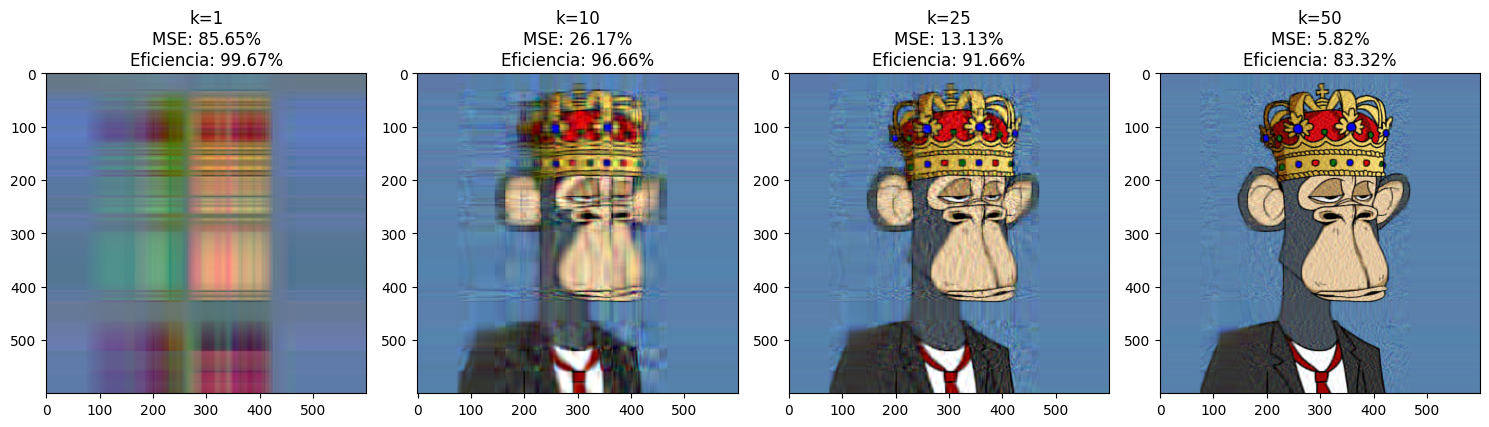

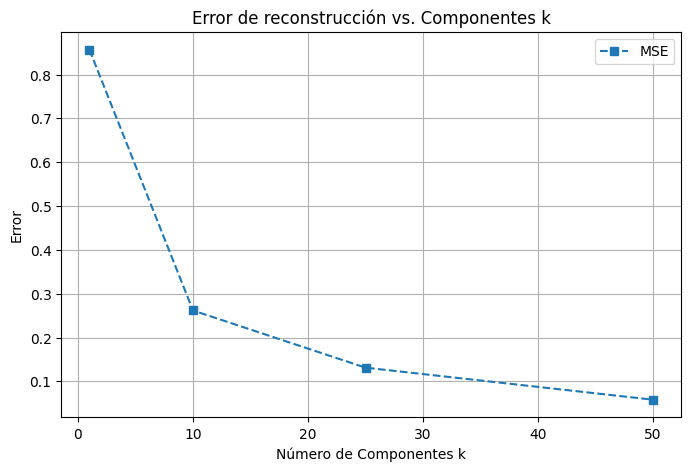

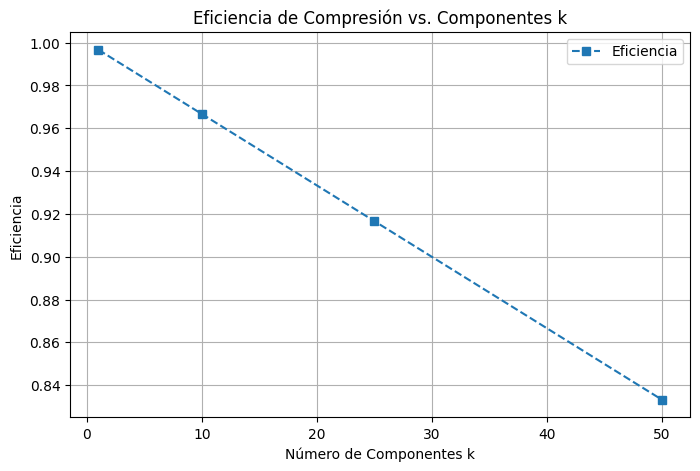

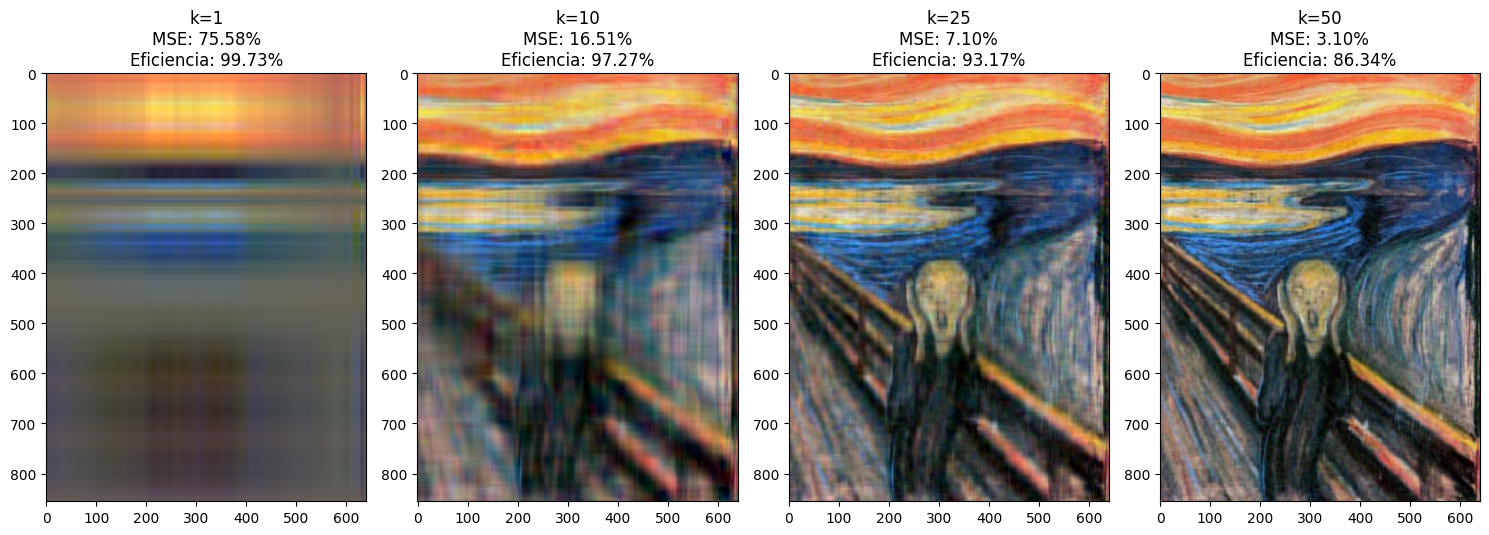

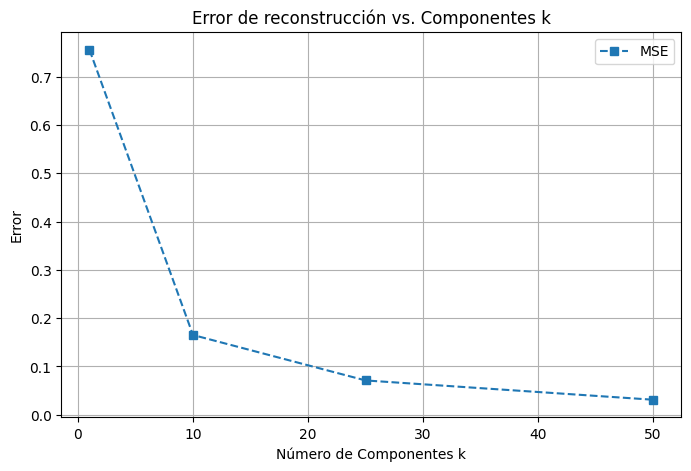

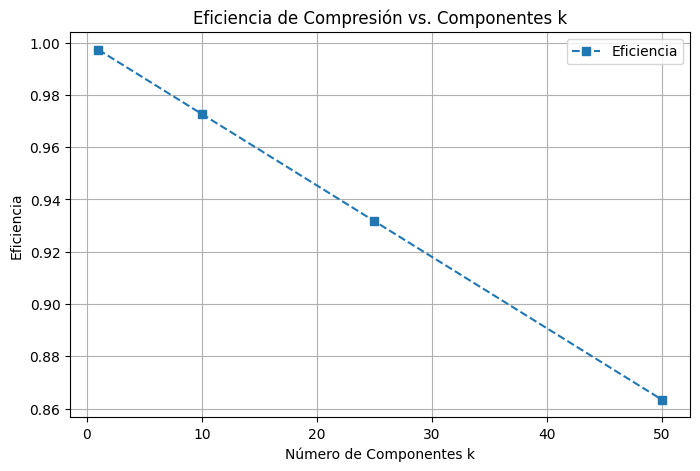

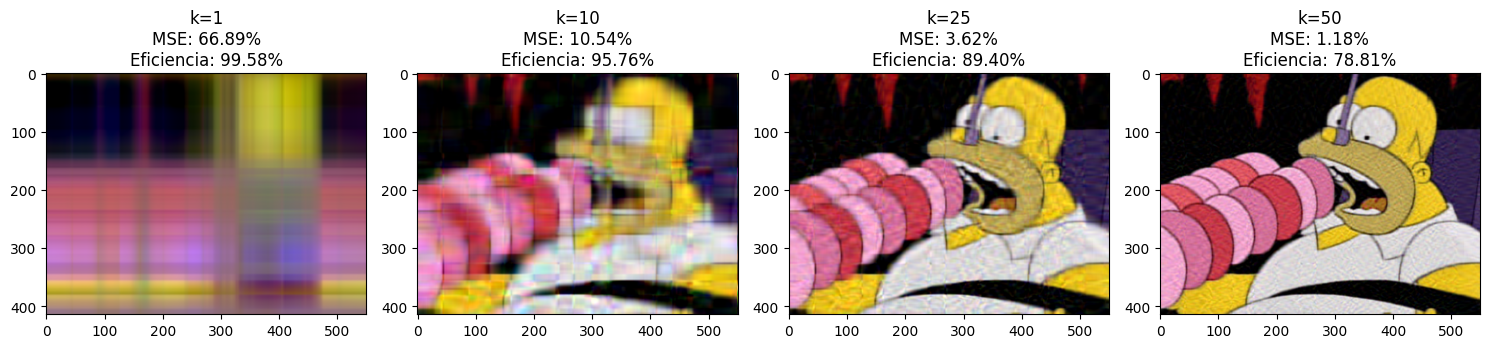

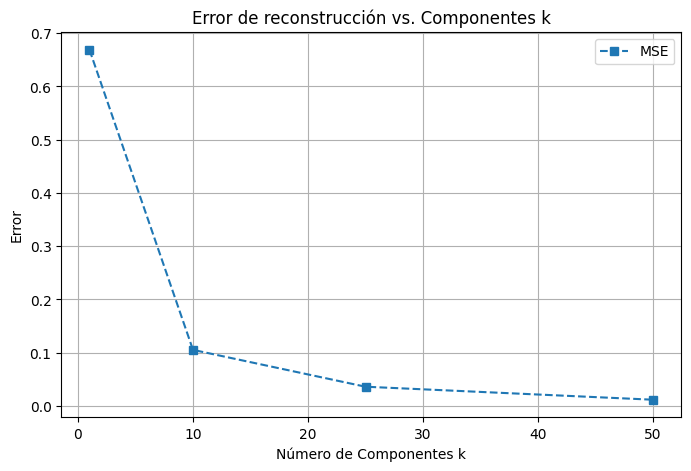

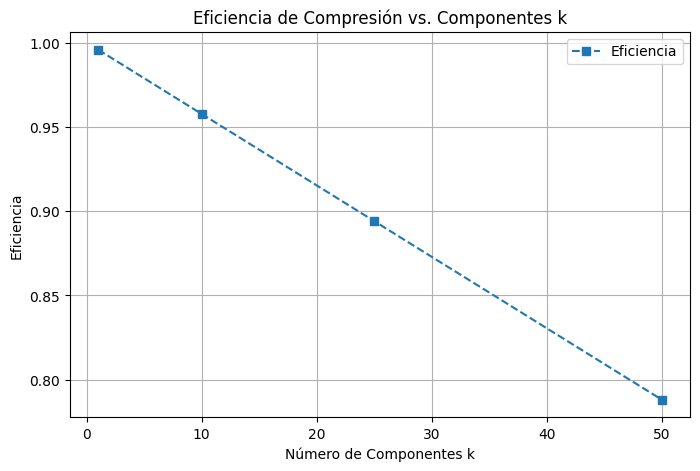

In [1241]:
k = [1, 10, 25, 50]
showImagesPCA(data=images, k_values=k)